<a href="https://colab.research.google.com/github/jwang44/Plucking-Style-Detection/blob/main/String_number_combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Preparation

In [ ]:
import numpy as np
import pickle
import glob, os

from collections import Counter
from statistics import stdev

#### Load features and labels of the two subsets and concatenate them

In [ ]:
with open('/content/drive/MyDrive/dataset1_pkl/MFCC.pkl', 'rb') as file:
    data1 = pickle.load(file)
with open('/content/drive/MyDrive/dataset1_pkl/STR_LABEL.pkl', 'rb') as file:
    string_labels1 = pickle.load(file)
with open('/content/drive/MyDrive/dataset1_pkl/PITCH_LABEL.pkl', 'rb') as file:
    pitch_labels1 = pickle.load(file)

with open('/content/drive/MyDrive/dataset2_pkl_mono/MFCC.pkl', 'rb') as file:
    data2 = pickle.load(file)
with open('/content/drive/MyDrive/dataset2_pkl_mono/STR_LABEL.pkl', 'rb') as file:
    string_labels2 = pickle.load(file)
with open('/content/drive/MyDrive/dataset2_pkl_mono/PITCH_LABEL.pkl', 'rb') as file:
    pitch_labels2 = pickle.load(file)

In [ ]:
data1 = np.vstack(data1)
string_labels1 = np.array(string_labels1)
pitch_labels1 = np.array(pitch_labels1)

data2 = np.vstack(data2)
string_labels2 = np.array(string_labels2) 
pitch_labels2 = np.array(pitch_labels2)

data = np.concatenate((data1, data2))
string_labels = np.concatenate((string_labels1, string_labels2))
pitch_labels = np.concatenate((pitch_labels1, pitch_labels2))

#### Filter the notes by removing the highest and lowest notes that can be played on only one string

In [ ]:
# midi note numbers corresponding to highest and lowest notes that can only be played on one string
mask = (pitch_labels>=45)&(pitch_labels<=83)
data_filtered = data[mask]
string_labels_filtered = string_labels[mask]
pitch_labels_filtered = pitch_labels[mask]

#### Save concatenated features and labels to new pickle

In [ ]:
with open('/content/drive/MyDrive/dataset1_2_pkl/MFCC.pkl', 'wb') as file:
    pickle.dump(data_filtered, file)
with open('/content/drive/MyDrive/dataset1_2_pkl/STR_LABEL.pkl', 'wb') as file:
    pickle.dump(string_labels_filtered, file)
with open('/content/drive/MyDrive/dataset1_2_pkl/PITCH_LABEL.pkl', 'wb') as file:
    pickle.dump(pitch_labels_filtered, file)

#### Load the features and labels

In [ ]:
from sklearn.preprocessing import Normalizer, LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.utils import shuffle
from statistics import stdev

In [ ]:
with open('/content/drive/MyDrive/dataset1_2_pkl/MFCC.pkl', 'rb') as file:
    data = pickle.load(file)
with open('/content/drive/MyDrive/dataset1_2_pkl/STR_LABEL.pkl', 'rb') as file:
    string_labels = pickle.load(file)

In [ ]:
print(Counter(string_labels))

Counter({4: 823, 5: 645, 2: 614, 3: 579, 6: 362, 1: 212})


In [ ]:
le = LabelEncoder()
string_labels = le.fit_transform(string_labels) # convert category from string to numerical

#### Train string number classifier

In [ ]:
# split into train and test
X = data
y = string_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
model = make_pipeline(StandardScaler(), SVC())
parameters = {
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
    'svc__C':[0.2, 1, 5], 
    'svc__gamma': ['scale', 'auto']
    }
clf = GridSearchCV(model, parameters, n_jobs=-1, refit=True, cv=10, return_train_score=True)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            

In [ ]:
clf.score(X_test, y_test)

0.9149922720247295

In [ ]:
Counter(y_test)

Counter({0: 58, 1: 119, 2: 128, 3: 153, 4: 123, 5: 66})

In [ ]:
clf.best_params_

{'svc__C': 5, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

In [ ]:
# Sanity check use normal Kfold
X = X_train
y = y_train
model = make_pipeline(StandardScaler(), SVC(C=5, gamma='scale'))
kf = KFold(n_splits=10, shuffle=True, random_state=42)
train_accus = []
val_accus = []
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model.fit(X_train, y_train)
    train_accus.append(model.score(X_train, y_train))
    val_accus.append(model.score(X_val, y_val))
train_accus = np.array(train_accus)
val_accus = np.array(val_accus)
print("-------------String Number Classification---------------")
print("train accu: ", train_accus.mean(), "Std dev: ", stdev(train_accus))
print("val accu: ", val_accus.mean(), "Std dev: ", stdev(val_accus))
print("test accu: ", model.score(X_test, y_test))

-------------String Number Classification---------------
train accu:  0.9935599467066674 Std dev:  0.0010323643242986869
val accu:  0.9049325072580887 Std dev:  0.023764531244855117
test accu:  0.9149922720247295


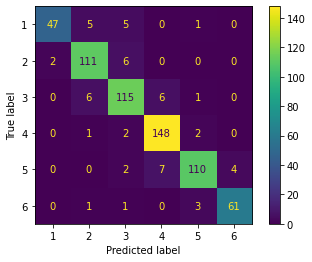

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test, display_labels=[1,2,3,4,5,6], values_format='d')  